In [1]:
import pandas as pd
import pyodbc
from catboost import CatBoostRegressor
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error   
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
server = '10.0.1.40' 
database = 'Ntier_EPIC' 
username = 'Sisenseuser' 
password = '!w@ntd@t@#123'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [26]:
query = """Select distinct t1.Service_ID,t1.Patient_Number,t5.patient_age,t1.Actual_Dr_Name,
            t1.Place_of_Service_Abbr,t1.Proc_Category_Abbr,t1.Type_of_Service_Abbr,t5.patient_zip_code,t5.patient_sex,
            t1.Original_Carrier_Name, t5.Patient_City, t5.Patient_State,t2.CoPayment,t2.CoInsurance,t1.Primary_Diagnosis_Code,t1.Procedure_Code,
            t1.Service_Units,convert(Date, t1.Service_Date_From) as Service_Date_From, t1.Claim_Number,
            convert(Date, t1.Original_Billing_Date) as Original_Billing_Date,Convert(Date, t2.Date_Paid) as Date_Paid,
            t1.Service_Fee,t2.Amount, t2.Allowed, t2.Deductible, t2.Transaction_Type, t4.Abbreviation,t4.Description, 
            t4.Self_Pay_TranCode
            from PM.vwGenSvcInfo as T1
            left join PM.[vwGenSvcPmtInfo] T2 ON T1.Service_Id=T2.Service_Id 
            left join PM.Reimbursement_Detail T3 on T1.Service_Id=T3.Service_Id
            left join [dbo].[vUAI_Transaction_Codes] T4 ON T2.Transaction_Code_Abbr=T4.Abbreviation
            left join [EMR].[HPSITE].[DEMOGRAPHICS_VIEW] as d on t1.Patient_Number = d.DEM_EXTERNALID
            left join PM.vwGenPatInfo as T5 ON T1.Patient_Number=T5.Patient_Number
            where (T4.Self_Pay_TranCode=0)
            and (T4.Description not like '%Self%' And T4.Description not like '%Adj%') And (T2.Transaction_Type !='A') and 
            (T2.Transaction_Type !='T') and (T2.Transaction_Type !='B') and (T1.Service_Fee >0)  and (t2.Amount >= 0) and
            ((t1.Primary_Diagnosis_Code between 'E08' and 'E13') OR (t1.Primary_Diagnosis_Code='R73.03'))
            and t2.Date_Paid >= DATEADD(day, -455, GETDATE())
           AND t1.Service_Date_From between DATEADD(month,-15,GETDATE()) and DATEADD(month,-3,GETDATE())"""

df = pd.read_sql(query,cnxn)

In [27]:
df.shape

(91803, 29)

In [32]:
data = df.copy()
data.head() 

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode
0,5112257,391370,51,Mary Girjis PA-C,EPS10Mil,EVALMGMT,MEDICAL,48335,M,Blue Cross Complete (Medicaid),...,2023-02-18,2023-03-15,220.0,125.62,125.62,NaN,P,MDPMT,Medicaid Payment,False
1,3595612,330360,73,Deena Chabaan PA-C,EP Fer,HCPCS_G,OTHER,48030,F,Priority Health Medicare,...,2022-06-03,2022-06-09,295.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False
2,4467164,761070,64,Kara Wertz PA-C,EP Fer,LAB CHEM,LAB,48017,F,WellCare Health Plan,...,2022-11-04,2022-12-02,66.0,0.00,16.80,NaN,P,MDPMT,Medicaid Payment,False
3,3952805,742160,17,"Eric Mozurkewich NP-C,RN",EPDLiv,HCPCS_G,OTHER,48240,F,BCBS of Michigan,...,2022-08-02,2022-08-10,158.4,107.39,114.24,NaN,P,BCBSPMT,BCBS Payment,False
4,4514067,022875,83,Jennifer Ponkowski PA-C,EP Fer,LAB CHEM,LAB,48025,F,Medicare Mr,...,2022-11-11,2022-11-28,10.0,3.41,3.48,NaN,P,MRPMT,Medicare Payment,False


In [33]:
data=data.drop_duplicates()

In [34]:
data.shape

(91803, 29)

In [35]:
data.isna().sum()

Service_ID                    0
Patient_Number                0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Original_Carrier_Name       270
Patient_City                  0
Patient_State                 0
CoPayment                 88876
CoInsurance               83173
Primary_Diagnosis_Code        0
Procedure_Code                0
Service_Units                 0
Service_Date_From             0
Claim_Number                  0
Original_Billing_Date       349
Date_Paid                     0
Service_Fee                   0
Amount                        0
Allowed                   28880
Deductible                87500
Transaction_Type              0
Abbreviation                  0
Description                   0
Self_Pay_TranCode             0
dtype: int64

In [36]:
data = data.dropna(subset = ['Original_Billing_Date','Date_Paid','Original_Carrier_Name'])

In [37]:
data["Original_Billing_Date"] = pd.to_datetime(data["Original_Billing_Date"])      
data["Date_Paid"] = pd.to_datetime(data["Date_Paid"]) 

In [38]:
data["Delay_in_days"] = (pd.to_datetime(data["Date_Paid"]) - pd.to_datetime(data["Original_Billing_Date"])).dt.days
data=data[(data['Delay_in_days'] >= 0) & (data['Delay_in_days'] <= 365)]
data = data.drop(['Delay_in_days'],axis='columns')

In [39]:
data.Amount.describe()

count    89982.000000
mean        15.798017
std         33.433565
min          0.000000
25%          0.000000
50%          2.480000
75%          9.710000
max        354.000000
Name: Amount, dtype: float64

In [40]:
## Score Calculation

In [41]:
#Payment component Calculation

def q3(x):
    """function to return 3rd quartile"""
    return x.quantile(0.75)


In [42]:
data['Amount_per_serv_unit'] = data['Amount']/data['Service_Units']

In [43]:
## finding the q3 for a given cpt by a given payer
cpt_payment_q3 = data.groupby(['Original_Carrier_Name', 'Procedure_Code']).agg({'Amount_per_serv_unit':q3})
cpt_payment_dict = cpt_payment_q3.to_dict('dict')['Amount_per_serv_unit']

## function for calculating the payout_ratio
def get_payout_ratio(row):
    cpt = row['Procedure_Code']
    payor=row['Original_Carrier_Name']
    amt=row['Amount_per_serv_unit']
    med_payout=cpt_payment_dict[payor,str(cpt)]

            
    if med_payout == 0:
        if amt > med_payout:
            payout_ratio = 1
        else:
            payout_ratio = 0
    else:
        if amt > med_payout:
            amt = med_payout
        
        payout_ratio = amt/med_payout
    
    return payout_ratio

In [44]:
# Applying the function to the 'Amount' column
data['payout_ratio'] = data[['Procedure_Code','Original_Carrier_Name','Amount_per_serv_unit']].apply(get_payout_ratio,axis=1)
data['payout_ratio'] = data['payout_ratio'].round(2)

In [45]:
data.payout_ratio.describe()

count    89982.000000
mean         0.486448
std          0.485643
min          0.000000
25%          0.000000
50%          0.440000
75%          1.000000
max          1.000000
Name: payout_ratio, dtype: float64

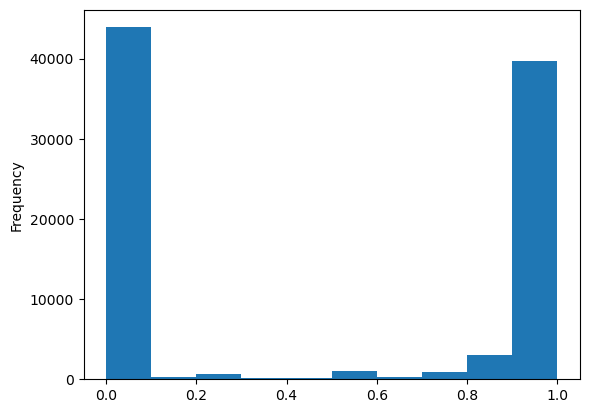

In [46]:
import matplotlib.pyplot as plt
import numpy as np
data.payout_ratio.plot(kind='hist');plt.show()

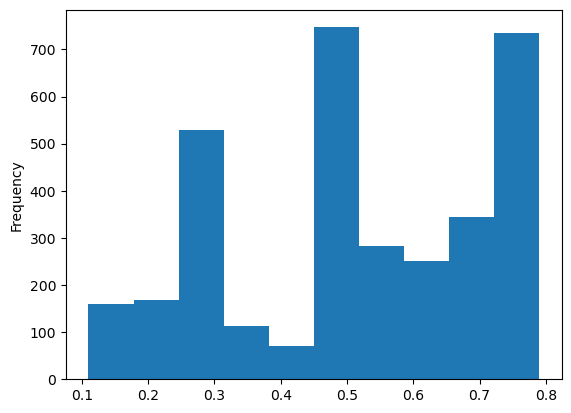

In [47]:
data[(data.payout_ratio<0.8) & (data.payout_ratio>0.1)].payout_ratio.plot(kind='hist');plt.show()

In [48]:
## Delay element
# data["time_decay"] = (1 - (data["Delay_in_days"] / 365))

def get_delay(row):
    
    date_paid = row['Date_Paid']
    billing_date = row['Original_Billing_Date']
    
    diff = (date_paid - billing_date).days
    
    amt = row["Amount"]
    
    if amt == 0:
        return 0
    else:
        return diff
    
data['delay_in_days'] = data[['Original_Billing_Date','Date_Paid','Amount']].apply(get_delay,axis=1)

In [49]:
## finding the median payment for a given cpt by a given payer
cpt_delay_max = data.groupby(['Original_Carrier_Name', 'Procedure_Code'])[['delay_in_days']].max()
cpt_delay_dict = cpt_delay_max.to_dict('dict')['delay_in_days']

## function for calculating the payout_ratio
def get_normed_delay(row):
    cpt = row['Procedure_Code']
    payor = row['Original_Carrier_Name']
    amt = row['Amount']
    delay = row['delay_in_days']
    max_delay = cpt_delay_dict[payor,str(cpt)]
    
    if amt == 0:
        delay_normed = 0
    else:
        try:
            delay_normed = 1 - (delay/max_delay)
        except ZeroDivisionError:
            delay_normed = 0

#     print('delay',delay)
#     print('max delay',max_delay)
#     print('normed',delay_normed)
    
    return delay_normed

In [50]:
data['normalized_delay'] = data[['Procedure_Code','Original_Carrier_Name','Amount','delay_in_days']].apply(get_normed_delay,axis=1)

In [51]:
data.normalized_delay.describe()

count    89982.000000
mean         0.415512
std          0.442701
min          0.000000
25%          0.000000
50%          0.000000
75%          0.927481
max          0.993750
Name: normalized_delay, dtype: float64

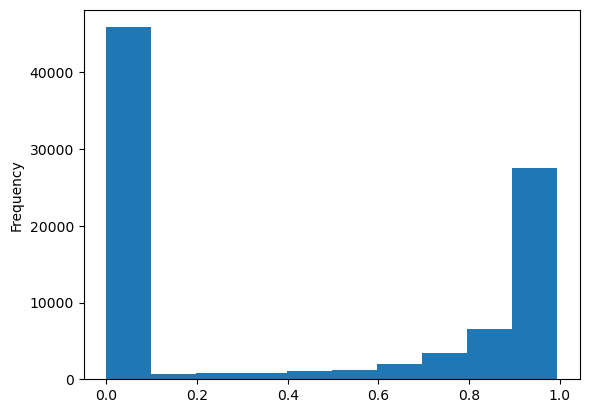

In [52]:
data.normalized_delay.plot(kind='hist');plt.show()

In [53]:
# Final score
payment_wt = 0.75
delay_wt = 0.25

data["Score"] = (payment_wt * data["payout_ratio"]) + (delay_wt * data["normalized_delay"])   
data.head() 

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode,Amount_per_serv_unit,payout_ratio,delay_in_days,normalized_delay,Score
0,5112257,391370,51,Mary Girjis PA-C,EPS10Mil,EVALMGMT,MEDICAL,48335,M,Blue Cross Complete (Medicaid),...,NaN,P,MDPMT,Medicaid Payment,False,125.62,1.0,25,0.841772,0.960443
1,3595612,330360,73,Deena Chabaan PA-C,EP Fer,HCPCS_G,OTHER,48030,F,Priority Health Medicare,...,NaN,P,MRPMT,Medicare Payment,False,0.00,0.0,0,0.000000,0.000000
2,4467164,761070,64,Kara Wertz PA-C,EP Fer,LAB CHEM,LAB,48017,F,WellCare Health Plan,...,NaN,P,MDPMT,Medicaid Payment,False,0.00,0.0,0,0.000000,0.000000
3,3952805,742160,17,"Eric Mozurkewich NP-C,RN",EPDLiv,HCPCS_G,OTHER,48240,F,BCBS of Michigan,...,NaN,P,BCBSPMT,BCBS Payment,False,107.39,1.0,8,0.957219,0.989305
4,4514067,022875,83,Jennifer Ponkowski PA-C,EP Fer,LAB CHEM,LAB,48025,F,Medicare Mr,...,NaN,P,MRPMT,Medicare Payment,False,3.41,1.0,17,0.930894,0.982724


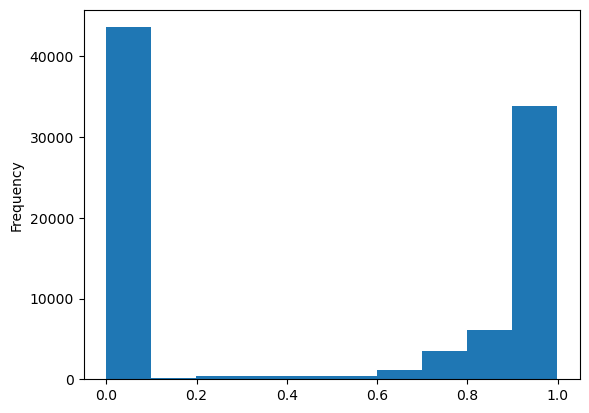

In [54]:
data.Score.plot(kind='hist');plt.show()

In [55]:
co_ins_df = data[~data.CoInsurance.isna()][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]
co_pay_df = data[~data.CoPayment.isna()][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]
co_ins_copay_df = data[~((data.CoInsurance.isna()) | (data.CoPayment.isna()))][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]
deductbl_df = data[~data.Deductible.isna()][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]

all_cpts = data.Procedure_Code.unique().tolist()
copay_cpts = co_pay_df.Procedure_Code.unique().tolist()
coins_cpts = co_ins_df.Procedure_Code.unique().tolist()
copay_coins = set(copay_cpts+coins_cpts)
len(all_cpts),len(copay_coins)

(101, 55)

In [56]:
co_ins_df.shape, co_pay_df.shape

((8415, 10), (2848, 10))

In [57]:
df_by_service_id = data.groupby(["Service_ID"], as_index=False).agg({
    "Patient_Number": "first",
    'patient_age': "max",
    'Actual_Dr_Name': 'first',
    'Place_of_Service_Abbr': 'first',
    'Proc_Category_Abbr': 'first',
    'Type_of_Service_Abbr': 'first',
    'patient_zip_code': "first",
    'patient_sex': "first",
    'Original_Carrier_Name': "first",
    'Patient_City': "first",
    'Patient_State': "first",
    'CoInsurance': "first",
    'CoPayment': "first",
    "Primary_Diagnosis_Code": "first",
    "Procedure_Code": "first",
    'Service_Units': "max",   #sum
    "Service_Fee": "max",
    'Allowed': 'max',
    'Deductible': 'max',
    "Amount":'sum',
    "Score": 'mean'    # sum
}
)


In [58]:
df_by_service_id.shape

(63540, 22)

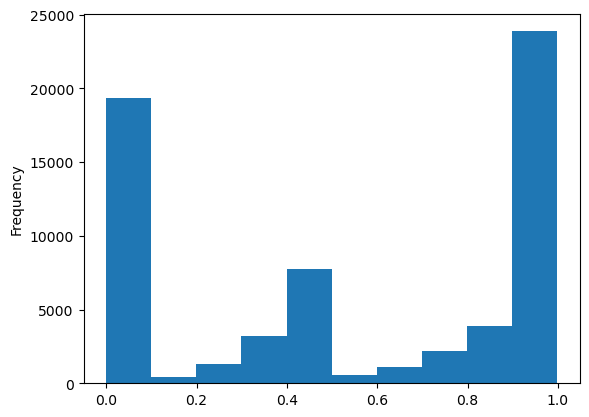

In [59]:
df_by_service_id.Score.plot(kind='hist');plt.show()

In [60]:
df_by_service_id=df_by_service_id[df_by_service_id.Amount <= df_by_service_id.Service_Fee]
df_by_service_id.shape

(63408, 22)

In [61]:
## Missing Value Treatment
df_by_service_id.isna().sum()

Service_ID                    0
Patient_Number                0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Original_Carrier_Name         0
Patient_City                  0
Patient_State                 0
CoInsurance               58742
CoPayment                 61224
Primary_Diagnosis_Code        0
Procedure_Code                0
Service_Units                 0
Service_Fee                   0
Allowed                   18816
Deductible                60354
Amount                        0
Score                         0
dtype: int64

In [62]:
df_by_service_id['CoInsurance'] = df_by_service_id.CoInsurance.fillna(0)
df_by_service_id['CoPayment'] = df_by_service_id.CoPayment.fillna(0)
df_by_service_id['Deductible'] = df_by_service_id.Deductible.fillna(0)

In [63]:
data.Allowed.isna().sum(),df_by_service_id.Allowed.isna().sum()

(28175, 18816)

In [64]:
df_by_service_id['Allowed_per_serv_unit'] = df_by_service_id['Allowed']/df_by_service_id['Service_Units']

In [65]:
## finding the mean 'Allowed' for a given cpt by a given payer
cpt_allowed_mean = df_by_service_id[~df_by_service_id['Allowed_per_serv_unit'].isna()].groupby(['Original_Carrier_Name', 'Procedure_Code'])[['Allowed_per_serv_unit']].mean()
cpt_allowed_dict = cpt_allowed_mean.to_dict('dict')['Allowed_per_serv_unit']

In [66]:
cpt_payer_allowed_dict = {}
for payer_cpt, alwd_value in cpt_allowed_dict.items():
    
    payer_name, cpt_name = payer_cpt
    
    try:
        cpt_payer_allowed_dict[cpt_name][payer_name] = alwd_value
    except KeyError:
        cpt_payer_allowed_dict[cpt_name] = {payer_name:alwd_value}
        

In [67]:
cpt_avg_allowed = {}
for cpt, payer_allwd in cpt_payer_allowed_dict.items():
    avg_allowed = sum(payer_allwd.values())/len(payer_allwd.values())
    cpt_avg_allowed[cpt] = avg_allowed

In [68]:
def get_payer_allowed_value(row):
    
    allowed = row['Allowed']

    if not np.isnan(allowed):
        
        payor_allowed = allowed
    
    else:
        
        cpt = row['Procedure_Code']
        payor = row['Original_Carrier_Name']
        
        
        try:
            payor_allowed = cpt_allowed_dict[payor,str(cpt)]
        except KeyError:
            try:
                payor_allowed = cpt_avg_allowed[cpt]
            except KeyError:
                payor_allowed = None
    return payor_allowed

In [69]:
df_by_service_id['Allowed'] = df_by_service_id.apply(get_payer_allowed_value,axis=1)

In [70]:
df_by_service_id.Allowed.isna().sum()

14

In [71]:
df_by_service_id[df_by_service_id.Allowed.isna()]['Procedure_Code'].unique()

array(['99406', '76881', '29580', '11055', 'G0447', '99173', '84153',
       '87389', '92568', '90471'], dtype=object)

In [76]:
df_by_service_id['Service_fee_per_serv_unit'] = df_by_service_id['Service_Fee']/df_by_service_id['Service_Units']
Qut=q3(df_by_service_id['Allowed_per_serv_unit']/df_by_service_id['Service_fee_per_serv_unit'])

In [440]:
cpt_avg_allowed['allowed_ratio_q3']=Qut

0.5191666666666667

In [78]:
df_by_service_id.loc[df_by_service_id['Allowed'].isna(), 'Allowed'] = df_by_service_id['Service_Fee']*Qut
## In the above line replace the hardcoded value 0.7 with calculated 3rd quartile for the allowed ratio (Allowed_per_su/Service_fee_per_su)

In [80]:
df_by_service_id.Allowed.isna().sum()

0

In [81]:
df_by_service_id.Allowed.describe()

count    63408.000000
mean        30.739630
std         44.810167
min          0.010000
25%          4.720000
50%          8.740000
75%         38.080000
max        354.000000
Name: Allowed, dtype: float64

In [143]:
df_by_service_id.columns

Index(['Service_ID', 'Patient_Number', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment',
       'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
       'Service_Fee', 'Allowed', 'Deductible', 'Amount', 'Score',
       'Allowed_per_serv_unit', 'Service_fee_per_serv_unit'],
      dtype='object')

In [144]:
#df_by_service1.to_excel("D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/Ml_model_aggregated_data.xlsx", index = False)
X = df_by_service_id.drop(['Score'],axis='columns')
y = df_by_service_id['Score']

In [145]:
X.columns

Index(['Service_ID', 'Patient_Number', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment',
       'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
       'Service_Fee', 'Allowed', 'Deductible', 'Amount',
       'Allowed_per_serv_unit', 'Service_fee_per_serv_unit'],
      dtype='object')

In [168]:
cat_cols = ['Patient_Number','Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'Primary_Diagnosis_Code', 'Procedure_Code']
dtype_dict = dict(zip(cat_cols,['category']*len(cat_cols)))


In [169]:
X = X.astype(dtype_dict)

In [216]:
X_orig = df_by_service_id.copy()

In [171]:
X_orig = X_orig.astype(dtype_dict)

In [172]:
train, test, cpt_train, cpt_test = train_test_split(X_orig, X_orig['Procedure_Code'], test_size=0.2, random_state=2023)

In [173]:
y_train = train['Score']
y_test = test['Score']
X_train = train.drop(['Score'],axis=1)
X_test = test.drop(['Score'],axis=1)

In [174]:
# Drop unneeded columns
cols_to_drop = ['Patient_Number','Service_ID', 'Amount','Allowed_per_serv_unit','Actual_Dr_Name','Place_of_Service_Abbr','Primary_Diagnosis_Code','Service_Fee','Service_fee_per_serv_unit']
X_train = X_train.drop(cols_to_drop,axis='columns')
X_test = X_test.drop(cols_to_drop,axis='columns')

In [175]:
X_train.shape, y_train.shape

((50726, 14), (50726,))

In [176]:
X_train.columns           

Index(['patient_age', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment',
       'Procedure_Code', 'Service_Units', 'Allowed', 'Deductible'],
      dtype='object')

In [997]:
# y = y*100

In [818]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [819]:
# X_train = X_train[['patient_age','patient_sex','Actual_Dr_Name','Procedure_Code','Original_Carrier_Name']]
# X_test = X_test[['patient_age','patient_sex','Actual_Dr_Name','Procedure_Code','Original_Carrier_Name']]

In [177]:
# catboost model after removing outliers and attributes
# List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
# Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ", cat_features)
cat_features = [int(i) for i in cat_features]

Names of categorical columns :  ['Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'Procedure_Code']
Location of categorical columns :  [1, 2, 3, 4, 5, 6, 7, 10]


In [178]:
from catboost import Pool
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                  )
# Creating pool object for test dataset
test_data = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features
                 )

# build model
print("model is training...")
print("----------------------")
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=True)
# Fit model
cat_model.fit(train_data)
print("Training completed...")
print("----------------------")

model is training...
----------------------
Learning rate set to 0.076139
0:	learn: 0.4027850	total: 64.9ms	remaining: 1m 4s
1:	learn: 0.3906350	total: 141ms	remaining: 1m 10s
2:	learn: 0.3767315	total: 206ms	remaining: 1m 8s
3:	learn: 0.3642208	total: 263ms	remaining: 1m 5s
4:	learn: 0.3535594	total: 324ms	remaining: 1m 4s
5:	learn: 0.3441341	total: 371ms	remaining: 1m 1s
6:	learn: 0.3351706	total: 441ms	remaining: 1m 2s
7:	learn: 0.3277564	total: 497ms	remaining: 1m 1s
8:	learn: 0.3212273	total: 563ms	remaining: 1m 1s
9:	learn: 0.3152822	total: 616ms	remaining: 1m
10:	learn: 0.3098220	total: 671ms	remaining: 1m
11:	learn: 0.3051460	total: 726ms	remaining: 59.8s
12:	learn: 0.3009776	total: 789ms	remaining: 59.9s
13:	learn: 0.2973282	total: 840ms	remaining: 59.2s
14:	learn: 0.2942160	total: 896ms	remaining: 58.8s
15:	learn: 0.2915160	total: 942ms	remaining: 57.9s
16:	learn: 0.2893482	total: 990ms	remaining: 57.2s
17:	learn: 0.2871845	total: 1.04s	remaining: 56.6s
18:	learn: 0.2853487	t

161:	learn: 0.2567861	total: 9.89s	remaining: 51.2s
162:	learn: 0.2567109	total: 9.95s	remaining: 51.1s
163:	learn: 0.2566158	total: 10s	remaining: 51s
164:	learn: 0.2565798	total: 10.1s	remaining: 50.9s
165:	learn: 0.2565321	total: 10.1s	remaining: 50.9s
166:	learn: 0.2565287	total: 10.2s	remaining: 50.8s
167:	learn: 0.2564278	total: 10.2s	remaining: 50.7s
168:	learn: 0.2563253	total: 10.3s	remaining: 50.6s
169:	learn: 0.2562641	total: 10.3s	remaining: 50.5s
170:	learn: 0.2562544	total: 10.4s	remaining: 50.4s
171:	learn: 0.2562262	total: 10.5s	remaining: 50.4s
172:	learn: 0.2561736	total: 10.5s	remaining: 50.3s
173:	learn: 0.2561286	total: 10.6s	remaining: 50.2s
174:	learn: 0.2560836	total: 10.6s	remaining: 50.1s
175:	learn: 0.2560428	total: 10.7s	remaining: 50.1s
176:	learn: 0.2559723	total: 10.8s	remaining: 50s
177:	learn: 0.2559460	total: 10.8s	remaining: 49.9s
178:	learn: 0.2558341	total: 10.9s	remaining: 49.9s
179:	learn: 0.2557799	total: 10.9s	remaining: 49.8s
180:	learn: 0.2556

320:	learn: 0.2490818	total: 19.3s	remaining: 40.8s
321:	learn: 0.2490377	total: 19.3s	remaining: 40.7s
322:	learn: 0.2490261	total: 19.4s	remaining: 40.7s
323:	learn: 0.2489726	total: 19.4s	remaining: 40.6s
324:	learn: 0.2489370	total: 19.5s	remaining: 40.5s
325:	learn: 0.2489193	total: 19.6s	remaining: 40.4s
326:	learn: 0.2488785	total: 19.6s	remaining: 40.4s
327:	learn: 0.2488113	total: 19.7s	remaining: 40.3s
328:	learn: 0.2487495	total: 19.8s	remaining: 40.3s
329:	learn: 0.2487328	total: 19.8s	remaining: 40.2s
330:	learn: 0.2486780	total: 19.9s	remaining: 40.2s
331:	learn: 0.2486774	total: 19.9s	remaining: 40.1s
332:	learn: 0.2486606	total: 20s	remaining: 40s
333:	learn: 0.2486467	total: 20.1s	remaining: 40s
334:	learn: 0.2486220	total: 20.1s	remaining: 39.9s
335:	learn: 0.2485911	total: 20.2s	remaining: 39.9s
336:	learn: 0.2485488	total: 20.2s	remaining: 39.8s
337:	learn: 0.2485153	total: 20.3s	remaining: 39.7s
338:	learn: 0.2485049	total: 20.3s	remaining: 39.7s
339:	learn: 0.2484

482:	learn: 0.2435654	total: 29s	remaining: 31.1s
483:	learn: 0.2435492	total: 29.1s	remaining: 31s
484:	learn: 0.2435400	total: 29.2s	remaining: 31s
485:	learn: 0.2435088	total: 29.2s	remaining: 30.9s
486:	learn: 0.2434120	total: 29.3s	remaining: 30.8s
487:	learn: 0.2434003	total: 29.3s	remaining: 30.8s
488:	learn: 0.2433623	total: 29.4s	remaining: 30.7s
489:	learn: 0.2433332	total: 29.5s	remaining: 30.7s
490:	learn: 0.2433183	total: 29.5s	remaining: 30.6s
491:	learn: 0.2433003	total: 29.6s	remaining: 30.5s
492:	learn: 0.2432835	total: 29.6s	remaining: 30.5s
493:	learn: 0.2432487	total: 29.7s	remaining: 30.4s
494:	learn: 0.2431517	total: 29.7s	remaining: 30.3s
495:	learn: 0.2431326	total: 29.8s	remaining: 30.3s
496:	learn: 0.2431093	total: 29.8s	remaining: 30.2s
497:	learn: 0.2430926	total: 29.9s	remaining: 30.1s
498:	learn: 0.2430574	total: 30s	remaining: 30.1s
499:	learn: 0.2430327	total: 30s	remaining: 30s
500:	learn: 0.2430183	total: 30.1s	remaining: 29.9s
501:	learn: 0.2429941	to

642:	learn: 0.2391398	total: 38.2s	remaining: 21.2s
643:	learn: 0.2391333	total: 38.2s	remaining: 21.1s
644:	learn: 0.2391210	total: 38.3s	remaining: 21.1s
645:	learn: 0.2391044	total: 38.4s	remaining: 21s
646:	learn: 0.2390847	total: 38.4s	remaining: 21s
647:	learn: 0.2390517	total: 38.5s	remaining: 20.9s
648:	learn: 0.2390224	total: 38.5s	remaining: 20.8s
649:	learn: 0.2389884	total: 38.6s	remaining: 20.8s
650:	learn: 0.2389661	total: 38.7s	remaining: 20.7s
651:	learn: 0.2389377	total: 38.7s	remaining: 20.7s
652:	learn: 0.2389139	total: 38.8s	remaining: 20.6s
653:	learn: 0.2388921	total: 38.8s	remaining: 20.5s
654:	learn: 0.2388805	total: 38.9s	remaining: 20.5s
655:	learn: 0.2388600	total: 39s	remaining: 20.4s
656:	learn: 0.2388331	total: 39s	remaining: 20.4s
657:	learn: 0.2388235	total: 39.1s	remaining: 20.3s
658:	learn: 0.2387444	total: 39.1s	remaining: 20.2s
659:	learn: 0.2387130	total: 39.2s	remaining: 20.2s
660:	learn: 0.2386578	total: 39.2s	remaining: 20.1s
661:	learn: 0.238591

802:	learn: 0.2355475	total: 48.4s	remaining: 11.9s
803:	learn: 0.2355378	total: 48.4s	remaining: 11.8s
804:	learn: 0.2354767	total: 48.5s	remaining: 11.7s
805:	learn: 0.2354591	total: 48.5s	remaining: 11.7s
806:	learn: 0.2354482	total: 48.6s	remaining: 11.6s
807:	learn: 0.2354366	total: 48.7s	remaining: 11.6s
808:	learn: 0.2354230	total: 48.7s	remaining: 11.5s
809:	learn: 0.2354141	total: 48.8s	remaining: 11.4s
810:	learn: 0.2354016	total: 48.8s	remaining: 11.4s
811:	learn: 0.2353848	total: 48.9s	remaining: 11.3s
812:	learn: 0.2353674	total: 49s	remaining: 11.3s
813:	learn: 0.2353636	total: 49s	remaining: 11.2s
814:	learn: 0.2353487	total: 49.1s	remaining: 11.1s
815:	learn: 0.2353483	total: 49.1s	remaining: 11.1s
816:	learn: 0.2353370	total: 49.2s	remaining: 11s
817:	learn: 0.2353105	total: 49.2s	remaining: 11s
818:	learn: 0.2352899	total: 49.3s	remaining: 10.9s
819:	learn: 0.2352833	total: 49.4s	remaining: 10.8s
820:	learn: 0.2352754	total: 49.4s	remaining: 10.8s
821:	learn: 0.235263

964:	learn: 0.2326905	total: 58.6s	remaining: 2.12s
965:	learn: 0.2326832	total: 58.6s	remaining: 2.06s
966:	learn: 0.2326634	total: 58.7s	remaining: 2s
967:	learn: 0.2326632	total: 58.8s	remaining: 1.94s
968:	learn: 0.2326290	total: 58.8s	remaining: 1.88s
969:	learn: 0.2326223	total: 58.9s	remaining: 1.82s
970:	learn: 0.2326074	total: 58.9s	remaining: 1.76s
971:	learn: 0.2325902	total: 59s	remaining: 1.7s
972:	learn: 0.2325760	total: 59s	remaining: 1.64s
973:	learn: 0.2325667	total: 59.1s	remaining: 1.58s
974:	learn: 0.2325542	total: 59.2s	remaining: 1.52s
975:	learn: 0.2325044	total: 59.2s	remaining: 1.46s
976:	learn: 0.2324823	total: 59.3s	remaining: 1.4s
977:	learn: 0.2324448	total: 59.3s	remaining: 1.33s
978:	learn: 0.2324388	total: 59.4s	remaining: 1.27s
979:	learn: 0.2324017	total: 59.5s	remaining: 1.21s
980:	learn: 0.2323837	total: 59.5s	remaining: 1.15s
981:	learn: 0.2323411	total: 59.6s	remaining: 1.09s
982:	learn: 0.2322867	total: 59.6s	remaining: 1.03s
983:	learn: 0.2322564

In [179]:
cat_model.score(X_test,y_test)

0.6871467452827378

In [180]:
# Prediction on train and test
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
print("----------------------")
print("Results and performance on the training and testing data")
print("----------------------")
print("Train set performance")
rmse = mean_squared_error(y_train, y_train_pred)**0.5
print("Root Mean squared error {:.3f}".format(rmse))
print("----------------------")
print("Test set performance")
rmse = mean_squared_error(y_test, y_test_pred)**0.5
print("Root Mean squared error {:.3f}".format(rmse))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

----------------------
Results and performance on the training and testing data
----------------------
Train set performance
Root Mean squared error 0.220
----------------------
Test set performance
Root Mean squared error 0.233


In [181]:
print("Training performance")
mean_abs_error = mean_absolute_error(y_train, y_train_pred)
print("Mean abs error {:.2f}".format(mean_abs_error))
print("----------------------")
print("Testing performance")
mean_abs_error = mean_absolute_error(y_test, y_test_pred)
print("Mean abs error {:.2f}".format(mean_abs_error))

Training performance
Mean abs error 0.15
----------------------
Testing performance
Mean abs error 0.16


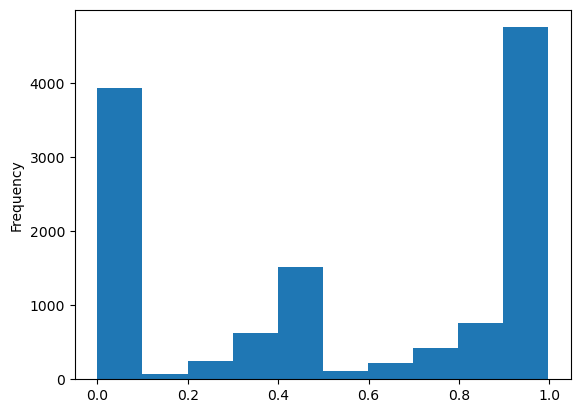

In [182]:
y_test.plot(kind='hist');plt.show()

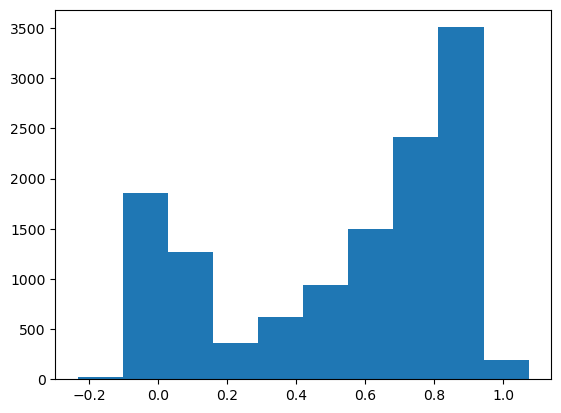

In [183]:
plt.hist(y_test_pred)
plt.show()

In [184]:
pred_df = pd.DataFrame({'cpt_code':cpt_test,'actual':y_test,'pred':y_test_pred,'abs_error':abs(y_test - y_test_pred)})

In [185]:
pred_df.head()

,cpt_code,actual,pred,abs_error
40820,82570,0.984954,0.698600,0.286354
32308,80053,0.550615,0.616861,0.066246
853,36415,0.000000,0.443932,0.443932
24680,82962,0.821429,0.503581,0.317848
7906,92250,0.090000,0.682195,0.592195


In [186]:
pred_df.abs_error.describe()

count    12682.000000
mean         0.163873
std          0.165925
min          0.000036
25%          0.046195
50%          0.110673
75%          0.227657
max          0.983078
Name: abs_error, dtype: float64

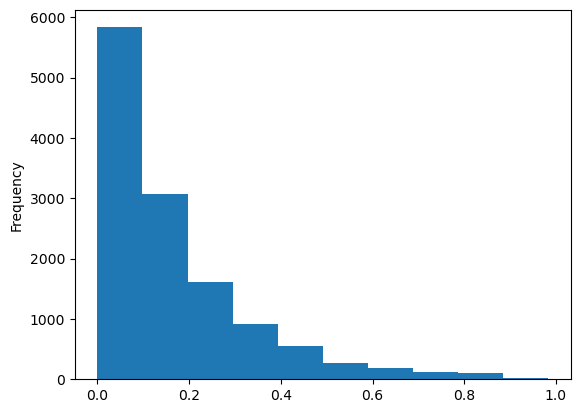

In [187]:
pred_df.abs_error.plot(kind='hist');plt.show()

In [188]:
(pred_df.abs_error<0.3).sum()/pred_df.shape[0]

0.8345686800189245

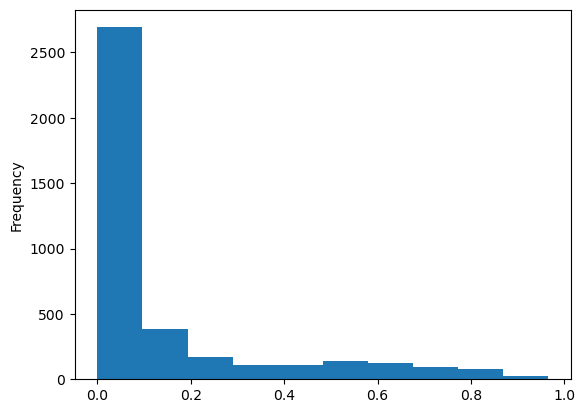

In [189]:
pred_df[pred_df.actual<0.10].abs_error.plot(kind='hist');plt.show()

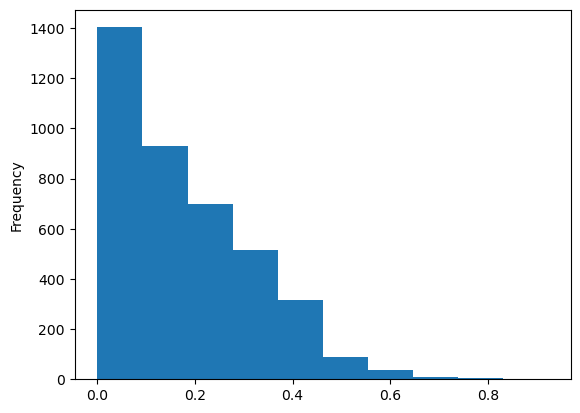

In [190]:
pred_df[(pred_df.actual>0.10) & (pred_df.actual<0.90)].abs_error.plot(kind='hist');plt.show()

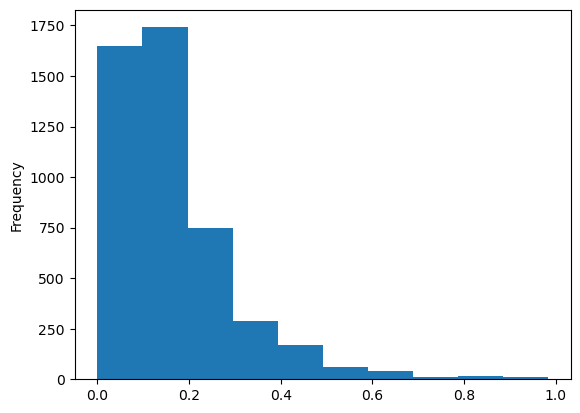

In [191]:
pred_df[pred_df.actual>0.90].abs_error.plot(kind='hist');plt.show()

# Also we should check error distribution for frequent CPTs (atleast 100 occurrances)

In [192]:
## Linear Regression
from sklearn.linear_model import LinearRegression

In [193]:
reg = LinearRegression()

# instead of dummification, we should do Label Encoding here, and then proceed

In [202]:
# X_train_dummified = pd.get_dummies(X_train)

# X_test_dummified = pd.get_dummies(X_test)

In [394]:
X_new = df_by_service_id.copy()

In [395]:
X_new.head()

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Primary_Diagnosis_Code,Procedure_Code,Service_Units,Service_Fee,Allowed,Deductible,Amount,Score,Allowed_per_serv_unit,Service_fee_per_serv_unit
0,3187492,706760,60,"Eric Mozurkewich NP-C,RN",EPDLiv,EVALMGMT,MEDICAL,48221,M,WellCare Health Plan,...,E11.319,99214,1.0,220.0,132.180000,0.0,132.18,0.989264,132.18,220.0
1,3187495,706760,60,"Eric Mozurkewich NP-C,RN",EPDLiv,LAB CHEM,LAB,48221,M,WellCare Health Plan,...,E11.319,36416,1.0,18.0,7.701153,0.0,0.00,0.000000,NaN,18.0
2,3187497,706760,60,"Eric Mozurkewich NP-C,RN",EPDLiv,LAB CHEM,LAB,48221,M,WellCare Health Plan,...,E11.319,82962,1.0,6.5,3.280000,0.0,3.28,0.995192,3.28,6.5
3,3187552,552880,63,Exercise Physiology,EPS10Mil,EVALMGMT,MEDICAL,48025,F,Molina Healthcare of Michigan Inc,...,E11.65,99213,1.0,170.0,77.190000,0.0,77.19,0.993881,77.19,170.0
4,3187757,563350,59,Exercise Physiology,EPS10Mil,EVALMGMT,MEDICAL,48235,F,Priority Health,...,E11.65,99213,1.0,170.0,93.880000,0.0,73.88,0.868333,93.88,170.0


In [396]:
X_new = X_new.astype(dtype_dict)

In [397]:
X_new.columns

Index(['Service_ID', 'Patient_Number', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment',
       'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
       'Service_Fee', 'Allowed', 'Deductible', 'Amount', 'Score',
       'Allowed_per_serv_unit', 'Service_fee_per_serv_unit'],
      dtype='object')

In [399]:
# Drop unneeded columns
cols_to_drop = ['Patient_Number','Service_ID', 'Actual_Dr_Name','Place_of_Service_Abbr','Service_Units','Type_of_Service_Abbr','Amount','Primary_Diagnosis_Code','Service_Fee','Allowed_per_serv_unit','Service_fee_per_serv_unit']
X_new = X_new.drop(cols_to_drop,axis='columns')

In [402]:
import os; os.getcwd()

'C:\\Users\\ShivashankarRampur'

In [405]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Proc_Category_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State','Procedure_Code']
label_save_path = r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/New_model"
for column in categorical_columns:
    label_encoder = LabelEncoder()
    label_encoder.fit(X_new[column])
    X_new[column] = label_encoder.transform(X_new[column])
    with open(os.path.join(label_save_path,'label_encoder_{}.pkl'.format(column)), 'wb') as f:
        pickle.dump(label_encoder, f)

In [407]:
import json

In [408]:
with open(os.path.join(label_save_path,'cat_cols_list.json'), 'w') as f:
    json.dump(categorical_columns,f)

In [415]:
cpt_allowed_dict_ = {"*and*".join(k):v for k,v in cpt_allowed_dict.items()} 

In [439]:
with open(os.path.join(label_save_path,'cpt_allowed_dict.json'), 'w') as f:
    json.dump(cpt_allowed_dict_,f)
with open(os.path.join(label_save_path,'cpt_avg_allowed.json'), 'w') as f:
    json.dump(cpt_avg_allowed,f)

In [419]:
X_new.head()

,patient_age,Proc_Category_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,Patient_City,Patient_State,CoInsurance,CoPayment,Procedure_Code,Allowed,Deductible,Score
0,60,4,328,1,89,48,4,0.0,0.0,68,132.180000,0.0,0.989264
1,60,8,328,1,89,48,4,0.0,0.0,6,7.701153,0.0,0.000000
2,60,8,328,1,89,48,4,0.0,0.0,28,3.280000,0.0,0.995192
3,63,4,41,0,59,16,4,0.0,0.0,67,77.190000,0.0,0.993881
4,59,4,350,0,68,48,4,0.0,20.0,67,93.880000,0.0,0.868333


In [420]:
train, test, cpt_train, cpt_test = train_test_split(X_new, X_new['Procedure_Code'], test_size=0.2, random_state=2023)

In [421]:
y_train = train['Score']
y_test = test['Score']
X_train = train.drop(['Score'],axis=1)
X_test = test.drop(['Score'],axis=1)

In [422]:
X_train.columns

Index(['patient_age', 'Proc_Category_Abbr', 'patient_zip_code', 'patient_sex',
       'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'CoInsurance',
       'CoPayment', 'Procedure_Code', 'Allowed', 'Deductible'],
      dtype='object')

In [423]:
X_train.shape, y_train.shape

((50726, 12), (50726,))

In [424]:
X_train.columns

Index(['patient_age', 'Proc_Category_Abbr', 'patient_zip_code', 'patient_sex',
       'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'CoInsurance',
       'CoPayment', 'Procedure_Code', 'Allowed', 'Deductible'],
      dtype='object')

In [425]:
X_train.isna().sum()

patient_age              0
Proc_Category_Abbr       0
patient_zip_code         0
patient_sex              0
Original_Carrier_Name    0
Patient_City             0
Patient_State            0
CoInsurance              0
CoPayment                0
Procedure_Code           0
Allowed                  0
Deductible               0
dtype: int64

In [426]:
reg.fit(X_train, y_train)

LinearRegression()

In [427]:
reg.score(X_test,y_test)

0.0688093586189733

In [428]:
train_preds = reg.predict(X_train)

lr_preds = reg.predict(X_test)

print("Training performance")
mean_sq_error = mean_absolute_error(y_train, train_preds)
print("Mean abs error {:.2f}".format(mean_sq_error))
print("----------------------")
print("Testing performance")
mean_sq_error = mean_absolute_error(y_test, lr_preds)
print("Mean abs error {:.2f}".format(mean_sq_error))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

Training performance
Mean abs error 0.36
----------------------
Testing performance
Mean abs error 0.36


In [429]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

In [430]:
rf = RandomForestRegressor(verbose=1,n_jobs=4,max_depth=20)
rf.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.1s finished


RandomForestRegressor(max_depth=20, n_jobs=4, verbose=1)

In [431]:
rf.score(X_test,y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7096874271840357

In [432]:
forest_importances = pd.Series(rf.feature_importances_, index=X_test.columns) # X_test_dummified.columns)

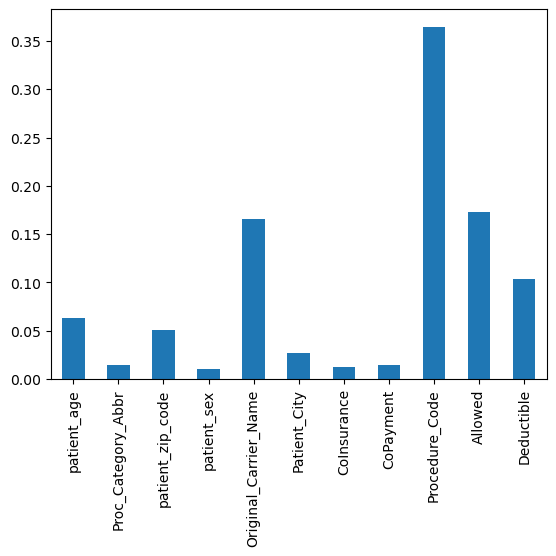

In [433]:
top_feat = forest_importances[forest_importances>0.005]
top_feat.plot.bar();plt.show()

In [434]:
rf_train_preds = rf.predict(X_train)     #X_train_dummified
rf_preds = rf.predict(X_test)

print("Train set performance")
mean_abs_error = mean_absolute_error(y_train, rf_train_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
print("----------------------")
print("Test set performance")
mean_abs_error = mean_absolute_error(y_test, rf_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Train set performance
Mean absolute error 0.10
----------------------
Test set performance
Mean absolute error 0.14


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [374]:
pred_df_rf = pd.DataFrame({'cpt_code':label_encoder.inverse_transform(cpt_test),'actual':y_test,'pred':rf_preds,'abs_error':abs(y_test - rf_preds)})

In [375]:
pred_df_rf

,cpt_code,actual,pred,abs_error
40820,82570,0.984954,0.771424,0.213529
32308,80053,0.550615,0.622816,0.072201
853,36415,0.000000,0.000000,0.000000
24680,82962,0.821429,0.528903,0.292525
7906,92250,0.090000,0.818963,0.728963
...,...,...,...,...
49314,82044,0.000000,0.010109,0.010109
27634,36416,0.000000,0.000000,0.000000
31773,36416,0.000000,0.000000,0.000000
6599,99490,0.972222,0.676254,0.295968


<AxesSubplot:ylabel='Frequency'>

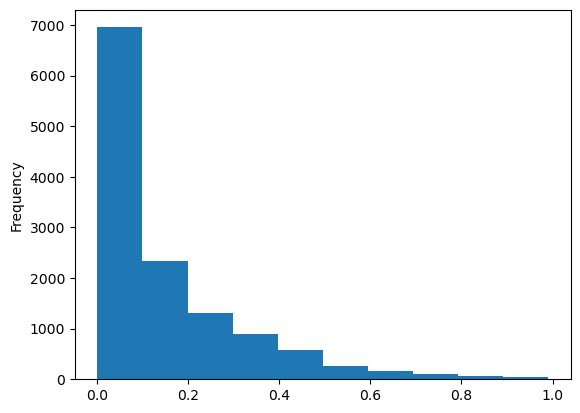

In [376]:
pred_df_rf.abs_error.plot(kind='hist')

In [377]:
pred_df_rf.abs_error.describe()

count    12682.000000
mean         0.144343
std          0.171871
min          0.000000
25%          0.013795
50%          0.082354
75%          0.212690
max          0.990558
Name: abs_error, dtype: float64

In [382]:
freq_cpts = pred_df_rf.cpt_code.value_counts()[pred_df_rf.cpt_code.value_counts()>100].index.tolist()

<AxesSubplot:ylabel='Frequency'>

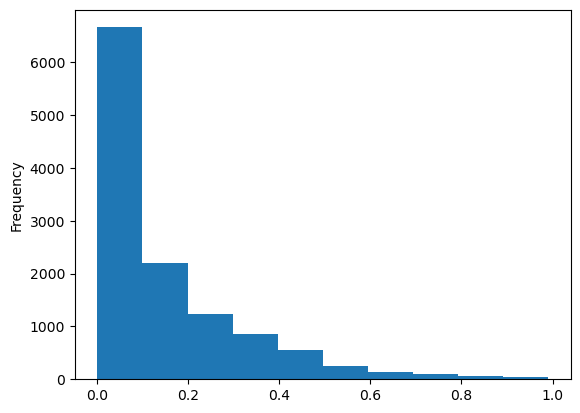

In [386]:
pred_df_rf[pred_df_rf.cpt_code.isin(freq_cpts)].abs_error.plot(kind='hist')

In [387]:
pred_df_rf[pred_df_rf.cpt_code.isin(freq_cpts) & (pred_df_rf.abs_error>0.6)]

,cpt_code,actual,pred,abs_error
7906,92250,0.090000,0.818963,0.728963
62200,83036,0.000000,0.754179,0.754179
15222,95250,0.978972,0.277964,0.701008
61885,99490,0.000000,0.609347,0.609347
63511,99439,0.000000,0.627756,0.627756
...,...,...,...,...
59335,92250,0.000000,0.631707,0.631707
1582,82570,0.996226,0.383953,0.612274
61204,83036,0.000000,0.783670,0.783670
57264,83036,0.000000,0.666063,0.666063


<AxesSubplot:ylabel='Frequency'>

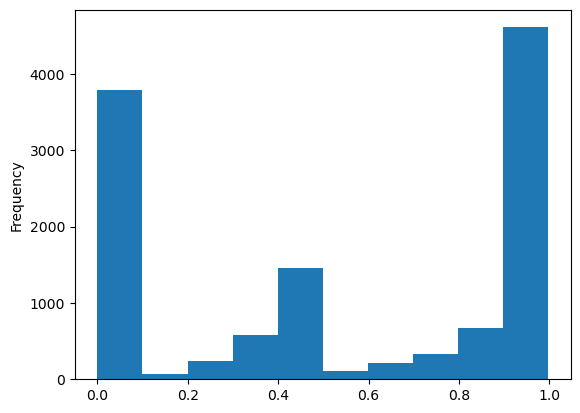

In [388]:
pred_df_rf[pred_df_rf.cpt_code.isin(freq_cpts)].actual.plot(kind='hist')

In [435]:
import pickle
# Save the model
with open('D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/New_model/rf.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [324]:
from catboost import Pool
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                  )
# Creating pool object for test dataset
test_data = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features
                 )

# build model
print("model is training...")
print("----------------------")
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=True)
# Fit model
cat_model.fit(train_data)
print("Training completed...")
print("----------------------")

model is training...
----------------------
Learning rate set to 0.076139
0:	learn: 0.4048877	total: 6.78ms	remaining: 6.77s
1:	learn: 0.3955090	total: 13.3ms	remaining: 6.65s
2:	learn: 0.3876445	total: 20.5ms	remaining: 6.81s
3:	learn: 0.3806903	total: 27.7ms	remaining: 6.9s
4:	learn: 0.3741249	total: 34.3ms	remaining: 6.83s
5:	learn: 0.3687660	total: 41ms	remaining: 6.79s
6:	learn: 0.3638742	total: 47.6ms	remaining: 6.75s
7:	learn: 0.3594774	total: 54ms	remaining: 6.69s
8:	learn: 0.3559478	total: 60ms	remaining: 6.6s
9:	learn: 0.3526005	total: 66ms	remaining: 6.53s
10:	learn: 0.3492755	total: 72ms	remaining: 6.48s
11:	learn: 0.3467899	total: 78.1ms	remaining: 6.43s
12:	learn: 0.3445727	total: 85.1ms	remaining: 6.46s
13:	learn: 0.3424722	total: 91ms	remaining: 6.41s
14:	learn: 0.3403454	total: 96.4ms	remaining: 6.33s
15:	learn: 0.3388068	total: 102ms	remaining: 6.28s
16:	learn: 0.3374623	total: 107ms	remaining: 6.19s
17:	learn: 0.3359413	total: 113ms	remaining: 6.14s
18:	learn: 0.3343

178:	learn: 0.2734664	total: 1.01s	remaining: 4.64s
179:	learn: 0.2733412	total: 1.02s	remaining: 4.64s
180:	learn: 0.2732653	total: 1.02s	remaining: 4.64s
181:	learn: 0.2730448	total: 1.03s	remaining: 4.63s
182:	learn: 0.2728970	total: 1.04s	remaining: 4.63s
183:	learn: 0.2727529	total: 1.04s	remaining: 4.62s
184:	learn: 0.2725548	total: 1.05s	remaining: 4.62s
185:	learn: 0.2724001	total: 1.05s	remaining: 4.61s
186:	learn: 0.2722822	total: 1.06s	remaining: 4.6s
187:	learn: 0.2721753	total: 1.06s	remaining: 4.6s
188:	learn: 0.2720993	total: 1.07s	remaining: 4.59s
189:	learn: 0.2719970	total: 1.07s	remaining: 4.58s
190:	learn: 0.2719269	total: 1.08s	remaining: 4.57s
191:	learn: 0.2718463	total: 1.08s	remaining: 4.57s
192:	learn: 0.2717941	total: 1.09s	remaining: 4.56s
193:	learn: 0.2717033	total: 1.09s	remaining: 4.55s
194:	learn: 0.2715678	total: 1.1s	remaining: 4.55s
195:	learn: 0.2714904	total: 1.11s	remaining: 4.54s
196:	learn: 0.2713678	total: 1.11s	remaining: 4.53s
197:	learn: 0.2

359:	learn: 0.2561273	total: 2.07s	remaining: 3.69s
360:	learn: 0.2560990	total: 2.08s	remaining: 3.68s
361:	learn: 0.2560612	total: 2.08s	remaining: 3.68s
362:	learn: 0.2560105	total: 2.09s	remaining: 3.67s
363:	learn: 0.2558759	total: 2.1s	remaining: 3.67s
364:	learn: 0.2558106	total: 2.1s	remaining: 3.66s
365:	learn: 0.2557558	total: 2.11s	remaining: 3.65s
366:	learn: 0.2556766	total: 2.12s	remaining: 3.65s
367:	learn: 0.2556020	total: 2.12s	remaining: 3.65s
368:	learn: 0.2555324	total: 2.13s	remaining: 3.64s
369:	learn: 0.2555107	total: 2.13s	remaining: 3.63s
370:	learn: 0.2555014	total: 2.14s	remaining: 3.63s
371:	learn: 0.2554563	total: 2.15s	remaining: 3.62s
372:	learn: 0.2553717	total: 2.15s	remaining: 3.62s
373:	learn: 0.2553104	total: 2.16s	remaining: 3.61s
374:	learn: 0.2552216	total: 2.16s	remaining: 3.61s
375:	learn: 0.2551161	total: 2.17s	remaining: 3.6s
376:	learn: 0.2550650	total: 2.18s	remaining: 3.6s
377:	learn: 0.2550303	total: 2.18s	remaining: 3.59s
378:	learn: 0.25

534:	learn: 0.2469344	total: 3.11s	remaining: 2.7s
535:	learn: 0.2468957	total: 3.12s	remaining: 2.7s
536:	learn: 0.2468544	total: 3.13s	remaining: 2.69s
537:	learn: 0.2468366	total: 3.13s	remaining: 2.69s
538:	learn: 0.2468133	total: 3.14s	remaining: 2.69s
539:	learn: 0.2467957	total: 3.14s	remaining: 2.68s
540:	learn: 0.2467137	total: 3.15s	remaining: 2.67s
541:	learn: 0.2466730	total: 3.15s	remaining: 2.67s
542:	learn: 0.2466178	total: 3.16s	remaining: 2.66s
543:	learn: 0.2466018	total: 3.17s	remaining: 2.65s
544:	learn: 0.2465666	total: 3.17s	remaining: 2.65s
545:	learn: 0.2465468	total: 3.18s	remaining: 2.64s
546:	learn: 0.2465250	total: 3.18s	remaining: 2.63s
547:	learn: 0.2464971	total: 3.19s	remaining: 2.63s
548:	learn: 0.2464456	total: 3.19s	remaining: 2.62s
549:	learn: 0.2463687	total: 3.2s	remaining: 2.62s
550:	learn: 0.2463191	total: 3.2s	remaining: 2.61s
551:	learn: 0.2462764	total: 3.21s	remaining: 2.6s
552:	learn: 0.2462063	total: 3.21s	remaining: 2.6s
553:	learn: 0.2461

709:	learn: 0.2400807	total: 4.16s	remaining: 1.7s
710:	learn: 0.2400550	total: 4.17s	remaining: 1.69s
711:	learn: 0.2399956	total: 4.18s	remaining: 1.69s
712:	learn: 0.2399692	total: 4.18s	remaining: 1.68s
713:	learn: 0.2399410	total: 4.19s	remaining: 1.68s
714:	learn: 0.2398985	total: 4.2s	remaining: 1.67s
715:	learn: 0.2398547	total: 4.2s	remaining: 1.67s
716:	learn: 0.2398481	total: 4.21s	remaining: 1.66s
717:	learn: 0.2398278	total: 4.21s	remaining: 1.65s
718:	learn: 0.2398021	total: 4.22s	remaining: 1.65s
719:	learn: 0.2397663	total: 4.22s	remaining: 1.64s
720:	learn: 0.2397270	total: 4.23s	remaining: 1.64s
721:	learn: 0.2396964	total: 4.24s	remaining: 1.63s
722:	learn: 0.2396685	total: 4.25s	remaining: 1.63s
723:	learn: 0.2396227	total: 4.25s	remaining: 1.62s
724:	learn: 0.2396169	total: 4.26s	remaining: 1.61s
725:	learn: 0.2395640	total: 4.26s	remaining: 1.61s
726:	learn: 0.2395609	total: 4.27s	remaining: 1.6s
727:	learn: 0.2395048	total: 4.28s	remaining: 1.6s
728:	learn: 0.239

877:	learn: 0.2347589	total: 5.19s	remaining: 721ms
878:	learn: 0.2347190	total: 5.2s	remaining: 715ms
879:	learn: 0.2346584	total: 5.2s	remaining: 709ms
880:	learn: 0.2346441	total: 5.21s	remaining: 704ms
881:	learn: 0.2346185	total: 5.22s	remaining: 698ms
882:	learn: 0.2345621	total: 5.22s	remaining: 692ms
883:	learn: 0.2345065	total: 5.23s	remaining: 686ms
884:	learn: 0.2344679	total: 5.24s	remaining: 680ms
885:	learn: 0.2343644	total: 5.24s	remaining: 674ms
886:	learn: 0.2343633	total: 5.25s	remaining: 669ms
887:	learn: 0.2343133	total: 5.25s	remaining: 663ms
888:	learn: 0.2342913	total: 5.26s	remaining: 657ms
889:	learn: 0.2342684	total: 5.26s	remaining: 651ms
890:	learn: 0.2342347	total: 5.27s	remaining: 645ms
891:	learn: 0.2342123	total: 5.28s	remaining: 639ms
892:	learn: 0.2341878	total: 5.28s	remaining: 633ms
893:	learn: 0.2341696	total: 5.29s	remaining: 627ms
894:	learn: 0.2341554	total: 5.29s	remaining: 621ms
895:	learn: 0.2341142	total: 5.3s	remaining: 615ms
896:	learn: 0.2

In [325]:
cat_model.score(X_test,y_test)

0.6677052172137385

In [291]:
# Prediction on train and test
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
print("----------------------")
print("Results and performance on the training and testing data")
print("----------------------")
print("Train set performance")
rmse = mean_squared_error(y_train, y_train_pred)**0.5
print("Root Mean squared error {:.3f}".format(rmse))
print("----------------------")
print("Test set performance")
rmse = mean_squared_error(y_test, y_test_pred)**0.5
print("Root Mean squared error {:.3f}".format(rmse))

----------------------
Results and performance on the training and testing data
----------------------
Train set performance
Root Mean squared error 0.232
----------------------
Test set performance
Root Mean squared error 0.241


In [292]:
## XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=4)

In [293]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

In [294]:
xgb.score(X_train,y_train),xgb.score(X_test,y_test)

(0.7430664909197587, 0.6962804387357078)

In [295]:
xgb_train_preds = xgb.predict(X_train)
xgb_preds = xgb.predict(X_test)

print("Train set performance")
mean_abs_error = mean_absolute_error(y_train, xgb_train_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
print("----------------------")
print("Test set performance")
mean_abs_error = mean_absolute_error(y_test, xgb_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

Train set performance
Mean absolute error 0.15
----------------------
Test set performance
Mean absolute error 0.17


In [ ]:
#Hyperparameter Tuning

In [443]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [445]:
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings('ignore')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[P

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 175 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBack

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 235 tasks      | 

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent wo

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 250 tasks      | 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBack

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[P

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 235 tasks      | 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[P

[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 175 tasks      | 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBack

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 179 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | 

[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[P

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | 

[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[P

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | 

[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | 

[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend

[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 179 tasks      | 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 179 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200

[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 179 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | 

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parall

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=20, n_jobs=4, verbose=1),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [446]:
print("Best Parameters are:", grid_search.best_params_)
print("Best Score is :",grid_search.best_score_)

Best Parameters are: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score is : 0.6695171624182812


### Model using 'allowed' for target var calculation 

In [1357]:
data_ald = df.copy()
data_ald.head() 

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode
0,3632971,060933,60,Esther Selik NP,EP Fer,OTHER,OTHER,48224,F,Hap,...,2022-06-11,2022-06-21,31.2,0.00,NaN,NaN,P,COMPMT,Commercial Ins. Payment,False
1,3651482,213200,58,Kristin Iannotti PA-C,EP Fer,LAB CHEM,LAB,48220,F,Medicare Mr,...,2022-06-21,2022-07-05,18.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False
2,5159299,731670,72,Shannon Webster PA-C,EPS10Mil,LAB CHEM,LAB,48075,F,Medicare Mr,...,2023-02-28,2023-03-29,22.0,0.00,NaN,NaN,P,MDPMT,Medicaid Payment,False
3,4999178,859160,57,Stacey Couch FNP,EP Fer,LAB CHEM,LAB,48227,F,Allied Benefit Systems Inc,...,2023-01-31,2023-03-07,18.0,6.25,6.25,NaN,P,COMPMT,Commercial Ins. Payment,False
4,3595612,330360,73,Deena Chabaan PA-C,EP Fer,HCPCS_G,OTHER,48030,F,Priority Health Medicare,...,2022-06-03,2022-06-09,295.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False


In [1358]:
data_ald = data_ald.drop_duplicates()
data_ald = data_ald.dropna(subset = ['Original_Billing_Date','Date_Paid','Original_Carrier_Name'])

In [1359]:
data_ald["Original_Billing_Date"] = pd.to_datetime(data_ald["Original_Billing_Date"])      
data_ald["Date_Paid"] = pd.to_datetime(data_ald["Date_Paid"]) 

In [1360]:
data_ald["Delay_in_days"] = (pd.to_datetime(data_ald["Date_Paid"]) - pd.to_datetime(data_ald["Original_Billing_Date"])).dt.days
data_ald=data_ald[(data_ald['Delay_in_days'] >= 0) & (data_ald['Delay_in_days'] <= 365)]
data_ald = data_ald.drop(['Delay_in_days'],axis='columns')

In [1383]:
data_ald_by_service_id = data_ald.groupby(["Service_ID"], as_index=False).agg({
    "Patient_Number": "first",
    'patient_age': "max",
    'Actual_Dr_Name': 'first',
    'Place_of_Service_Abbr': 'first',
    'Proc_Category_Abbr': 'first',
    'Type_of_Service_Abbr': 'first',
    'patient_zip_code': "first",
    'patient_sex': "first",
    'Original_Carrier_Name': "first",
    'Patient_City': "first",
    'Patient_State': "first",
    'CoInsurance': "max",
    'CoPayment': "max",
    "Primary_Diagnosis_Code": "first",
    "Procedure_Code": "first",
    'Service_Units': "max",   #sum
    "Service_Fee": "max",
    'Allowed': 'max',
    'Deductible': 'max',
    "Amount":'sum',
}
)


## Score Calculation

In [1385]:
#Payment component Calculation
data_ald_by_service_id['Amount_per_serv_unit'] = data_ald_by_service_id['Amount']/data_ald_by_service_id['Service_Units']

In [1390]:
data_ald.shape[0],data_ald.Allowed.isna().sum(),data_ald_by_service_id.Allowed.isna().sum()

(103612, 32117, 22370)

In [1387]:
data_ald_by_service_id['Allowed_per_serv_unit'] = data_ald_by_service_id['Allowed']/data_ald_by_service_id['Service_Units']

In [1388]:
data_ald_by_service_id.Allowed_per_serv_unit.isna().sum()

22370

In [1365]:
# Filling missing values in Allowed column

In [1391]:
## finding the mean 'Allowed' for a given cpt by a given payer
cpt_allowed_mean = data_ald_by_service_id[~data_ald_by_service_id['Allowed_per_serv_unit'].isna()].groupby(['Original_Carrier_Name', 'Procedure_Code'])[['Allowed_per_serv_unit']].mean()
cpt_allowed_dict = cpt_allowed_mean.to_dict('dict')['Allowed_per_serv_unit']

In [1392]:
cpt_payer_allowed_dict = {}
for payer_cpt, alwd_value in cpt_allowed_dict.items():
    
    payer_name, cpt_name = payer_cpt
    
    try:
        cpt_payer_allowed_dict[cpt_name][payer_name] = alwd_value
    except KeyError:
        cpt_payer_allowed_dict[cpt_name] = {payer_name:alwd_value}
        

In [1393]:
# cpt_allowed_dict = {cpt:list(d.values()) for cpt,d in cpt_payer_allowed_dict.items()}

In [1394]:
cpt_avg_allowed = {}
for cpt, payer_allwd in cpt_payer_allowed_dict.items():
    avg_allowed = sum(payer_allwd.values())/len(payer_allwd.values())
    cpt_avg_allowed[cpt] = avg_allowed

In [1395]:
def get_payer_allowed_value(row):
    
    allowed = row['Allowed_per_serv_unit']

    if not np.isnan(allowed):
        
        payor_allowed = allowed
    
    else:
        
        cpt = row['Procedure_Code']
        payor = row['Original_Carrier_Name']
        
        
        try:
            payor_allowed = cpt_allowed_dict[payor,str(cpt)]
        except KeyError:
            try:
                payor_allowed = cpt_avg_allowed[cpt]
            except KeyError:
                payor_allowed = None
    return payor_allowed

In [1407]:
data_ald_by_service_id['Allowed_per_serv_unit'] = data_ald_by_service_id.apply(get_payer_allowed_value,axis=1)

In [1408]:
data_ald_by_service_id.Allowed_per_serv_unit.isna().sum()

16

In [1409]:
data_ald_by_service_id['Service_Fee_per_serv_unit'] = data_ald_by_service_id['Service_Fee']/data_ald_by_service_id['Service_Units']

In [1410]:
data_ald_by_service_id['allowed_ratio'] = data_ald_by_service_id['Allowed_per_serv_unit']/data_ald_by_service_id['Service_Fee_per_serv_unit']

In [1411]:
data_ald_by_service_id['allowed_ratio'].describe()

count    75140.000000
mean         0.393713
std          0.186941
min          0.000028
25%          0.264167
50%          0.389167
75%          0.502188
max          1.360000
Name: allowed_ratio, dtype: float64

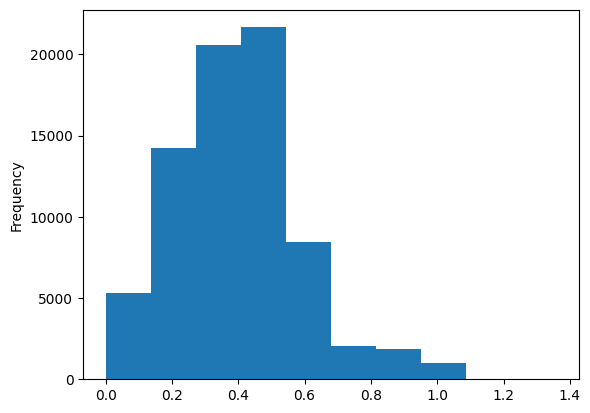

In [1412]:
data_ald_by_service_id['allowed_ratio'].plot(kind='hist');plt.show()

In [1413]:
allowed_ratio_q3 = data_ald_by_service_id['allowed_ratio'].quantile(0.75)

In [1414]:
allowed_ratio_q3

0.5021875

In [1415]:
data_ald_by_service_id.loc[data_ald_by_service_id['Allowed_per_serv_unit'].isna(), 'Allowed_per_serv_unit'] = data_ald_by_service_id['Service_Fee']*allowed_ratio_q3

In [1416]:
data_ald_by_service_id.Allowed_per_serv_unit.isna().sum()

0

In [1417]:
data_ald_by_service_id.Allowed.isna().sum()

22370

In [1418]:
data_ald_by_service_id.loc[data_ald_by_service_id['Allowed'].isna(), 'Allowed'] = data_ald_by_service_id['Allowed_per_serv_unit']*data_ald_by_service_id['Service_Units']

In [1419]:
data_ald_by_service_id.Allowed.isna().sum()

0

In [1420]:
# sid_ald_df = data_ald_by_service_id[['Service_ID','Allowed','Allowed_per_serv_unit']]
# data_ald = data_ald.drop(['Allowed','Allowed_per_serv_unit'],axis='columns')
# data_ald = data_ald.merge(sid_ald_df,how='left',on='Service_ID')
# data_ald['payout_ratio'] = data_ald.Amount/data_ald.Allowed

In [1424]:
data_ald_by_service_id['payout_ratio'] = data_ald_by_service_id.Amount/data_ald_by_service_id.Allowed

In [1425]:
data_ald_by_service_id['payout_ratio'].describe()

count    75156.000000
mean         1.223464
std        115.890899
min          0.000000
25%          0.000000
50%          0.979979
75%          1.000000
max      29500.000000
Name: payout_ratio, dtype: float64

In [1426]:
data_ald_by_service_id['payout_ratio'] = data_ald_by_service_id.payout_ratio.clip(upper=1)

In [1427]:
data_ald_by_service_id['payout_ratio'].describe()

count    75156.000000
mean         0.654371
std          0.449502
min          0.000000
25%          0.000000
50%          0.979979
75%          1.000000
max          1.000000
Name: payout_ratio, dtype: float64

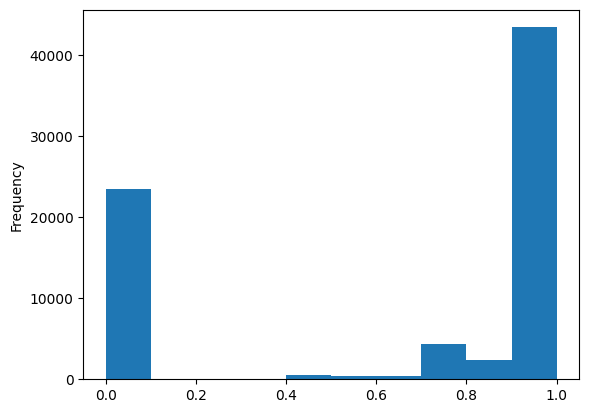

In [1428]:
data_ald_by_service_id.payout_ratio.plot(kind='hist');plt.show()

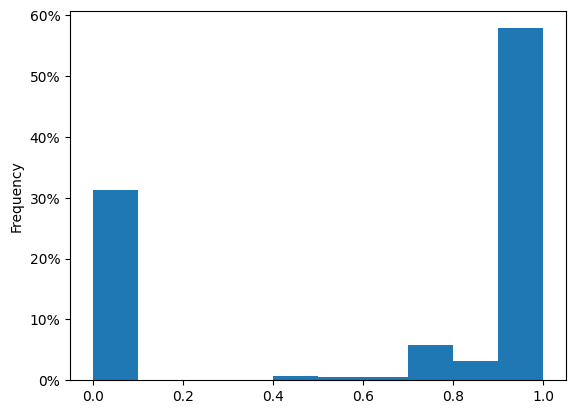

In [1430]:
from matplotlib.ticker import PercentFormatter

data_ald_by_service_id.payout_ratio.plot(kind='hist',weights=np.ones(len(data_ald_by_service_id)) / len(data_ald_by_service_id))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [1442]:
data_ald_by_service_id.Procedure_Code.value_counts()

36416    9959
83036    8659
82044    6163
82570    5522
99214    5130
         ... 
82728       1
99422       1
76700       1
87389       1
99222       1
Name: Procedure_Code, Length: 108, dtype: int64

In [1447]:
9600/75156

0.12773431262973017

In [1443]:
data_ald_by_service_id.shape

(75156, 26)

In [1450]:
data_ald_by_service_id[(data_ald_by_service_id.Procedure_Code=="36416") & (data_ald_by_service_id.Amount== 0)]

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Service_Units,Service_Fee,Allowed,Deductible,Amount,Amount_per_serv_unit,Allowed_per_serv_unit,Service_Fee_per_serv_unit,allowed_ratio,payout_ratio
0,3135709,617000,65,Mary Girjis PA-C,EPS10Mil,LAB CHEM,LAB,48203,F,Molina Medicare Choice Care,...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
9,3140261,275660,68,Tessa Adams PA-C,EPDLiv,LAB CHEM,LAB,48228,F,Medicare Mr,...,1.0,18.0,5.140000,NaN,0.0,0.0,5.140000,18.0,0.285556,0.0
11,3140288,430080,64,Tessa Adams PA-C,EPDLiv,LAB CHEM,LAB,48221,M,Blue Cross Complete (Medicaid),...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
14,3145167,644330,55,Christopher Gadoua PA-C,EPS10Mil,LAB CHEM,LAB,48045,M,Blue Cross Complete (Medicaid),...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
30,3146075,026527,52,Amber Kalabat FNP-BC,EPS10Mil,LAB CHEM,LAB,48072,F,Bcn,...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75122,5622462,790650,63,Allen Toubia FNP,EPSHarp,LAB CHEM,LAB,480662804,M,Meridian Health Plan Of MI(MEDICAID),...,1.0,22.0,7.680000,NaN,0.0,0.0,7.680000,22.0,0.349091,0.0
75134,5625500,553110,67,Kimberly Haggerty PA,EPDLiv,LAB CHEM,LAB,48221,F,WellCare Health Plan,...,1.0,22.0,7.777501,NaN,0.0,0.0,7.777501,22.0,0.353523,0.0
75140,5631035,319180,86,Kelly Wright,EP Fer,LAB CHEM,LAB,48322,M,Priority Health Medicare,...,1.0,22.0,7.777501,NaN,0.0,0.0,7.777501,22.0,0.353523,0.0
75147,5632340,362820,63,Frank Zuziak FNP-C,EPDLiv,LAB CHEM,LAB,48238,M,WellCare Health Plan,...,1.0,22.0,7.777501,NaN,0.0,0.0,7.777501,22.0,0.353523,0.0


In [1451]:
cpt_payer_allowed_dict['36416']

{'Administrative Concepts Inc': 8.392857142857142,
 'Aetna': 16.524166666666666,
 'Aetna Dual Complete': 18.0,
 'Aetna Medicare': 3.168275862068966,
 'Aetna Medicare Assure': 2.72,
 'Aetna Voluntary': 17.0825,
 'Aetna(Medicaid) Better Health of Mi': 4.5,
 'Alliance Health and Ins Co': 3.82,
 'Allied Benefit Systems Inc': 2.99,
 'BCBS of Michigan': 2.14,
 'BCBS of Michigan - Ep': 2.14,
 'Bind UnitedHealth Group': 1.98,
 'Champva': 8.57,
 'Cigna': 18.0,
 'Employee Benefit Logistics': 18.0,
 'Hap': 3.486666666666667,
 'Hap Preferred PPO': 3.82,
 'MEDICA': 1.98,
 'Mclaren Health Plan': 11.09235294117647,
 'Mclaren Medicaid Health Plan': 15.0,
 'Medicaid   Michigan  Mdch': 15.0,
 'Medicare  Mr': 5.14,
 'Meridian Health Plan Of MI(MEDICAID)': 7.68,
 'Meridian Healthcare of Mi': 7.68,
 'Meritain Health': 2.6,
 'Molina Marketplace': 10.59,
 'PHCS Limit Benefits Plan': 2.99,
 'Paramount Healthcare': 2.72,
 'Trustmark Health Benefits': 2.79,
 'UMR': 8.108225806451614,
 'United Healthcare': 1.979

In [1441]:
data_ald_by_service_id[data_ald_by_service_id.payout_ratio==0].Procedure_Code.value_counts()[data_ald_by_service_id[data_ald_by_service_id.payout_ratio==0].Procedure_Code.value_counts()>5]

36416    9608
36415    1727
82570    1522
82962    1132
92250    1006
83036    1001
82044     862
80053     654
99214     653
81002     646
G0506     505
G9001     477
G9008     473
84443     439
80061     427
93922     288
99051     233
99490     209
G9002     142
1111F     140
95250     139
95251     136
99489     136
93000     134
99439     108
85025      88
80048      74
G9007      71
94690      64
99204      62
99213      60
82043      54
99487      41
99211      22
84439      11
99203      10
Name: Procedure_Code, dtype: int64